In [1]:
import pandas as pd
import numpy as np
import math 
from datetime import datetime
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import matplotlib.pyplot as plt  
import seaborn as sns

In [2]:
# Import the data data
subscriptions = pd.read_csv('subscriptionsdataFINAL.csv') 
visitation_part1 = pd.read_csv('visitationdataPART1.csv') 
visitation_part2 = pd.read_csv('visitationdataPART2.csv')  

In [3]:
# Change the timestamp
subscriptions_1 = subscriptions.copy()
subscriptions_1['Join Date'] =  pd.to_datetime(subscriptions_1['Join Date'].str.upper(), format='%b-%y', yearfirst=False)
subscriptions_1['Join_year'] = pd.DatetimeIndex(subscriptions_1['Join Date']).year
subscriptions_1['End Date'] =  pd.to_datetime(subscriptions_1['End Date'].str.upper(), format='%b-%y', yearfirst=False)
subscriptions_1.dropna()
subscriptions_1.head()

,Club,Join Date,Affluence,Gender,Subscription Type,End Date,CustomerID,BirthYear,Join_year
0,Enfield,2011-12-01,C1,Male,Standard,2011-12-01,1,1992,2011
1,Greenwich,2018-06-01,A,Female,Standard,NaT,2,1972,2018
2,Islington,2018-03-01,B,Female,Standard,2018-10-01,3,1985,2018
3,Hounslow,2015-10-01,C1,Female,Standard,2015-12-01,4,1972,2015
4,Barnet,2015-05-01,C2,Male,Standard,2015-12-01,5,1982,2015


In [4]:
# Add Duration 
subscriptions_2 = subscriptions_1.copy()
date_min = min (subscriptions_2['Join Date'].min(),subscriptions_2['End Date'].min() )
date_max = max (subscriptions_2['Join Date'].max(),subscriptions_2['End Date'].max() )
dates = pd.date_range(date_min, date_max, freq = 'MS')
subscriptions_2['Duration'] = np.where(subscriptions_2['End Date'].isna(), 
                                     (date_max - subscriptions_2['Join Date']), 
                                     (subscriptions_2['End Date'] - subscriptions_2['Join Date']) )
subscriptions_2['Duration'] = (subscriptions_2['Duration'] /  np.timedelta64(1, 'M') ).apply(math.floor)
subscriptions_2

,Club,Join Date,Affluence,Gender,Subscription Type,End Date,CustomerID,BirthYear,Join_year,Duration
0,Enfield,2011-12-01,C1,Male,Standard,2011-12-01,1,1992,2011,0
1,Greenwich,2018-06-01,A,Female,Standard,NaT,2,1972,2018,6
2,Islington,2018-03-01,B,Female,Standard,2018-10-01,3,1985,2018,7
3,Hounslow,2015-10-01,C1,Female,Standard,2015-12-01,4,1972,2015,2
4,Barnet,2015-05-01,C2,Male,Standard,2015-12-01,5,1982,2015,7
...,...,...,...,...,...,...,...,...,...,...
850028,Lewisham,2018-12-01,A,Male,Standard,NaT,850029,1995,2018,0
850029,Tower Hamlets,2013-10-01,B,Male,Standard,2014-02-01,850030,1987,2013,4
850030,Redbridge,2018-05-01,C1,Female,Standard,2018-09-01,850031,1985,2018,4
850031,Camden,2017-07-01,B,Female,Standard,2017-09-01,850032,1978,2017,2


In [5]:
# Add Type of Customers
subscriptions_3= subscriptions_2.copy()
visitation_part1_peakvisit = visitation_part1.groupby(['CustomerID', 'peakvisits']).size().unstack(fill_value=0)
visitation_part2_peakvisit = visitation_part2.groupby(['CustomerID', 'peakvisits']).size().unstack(fill_value=0)
visitation_peakvisit = pd.merge(visitation_part1_peakvisit,visitation_part2_peakvisit,on='CustomerID',how='outer').sort_index().replace({np.nan:0})
visitation_peakvisit['False'] = visitation_peakvisit['False_x'] + visitation_peakvisit['False_y']
visitation_peakvisit['True'] = visitation_peakvisit['True_x'] + visitation_peakvisit['True_y']
visitation_peakvisit=visitation_peakvisit.drop(columns=['False_x','True_x','False_y','True_y'])
visitation_peakvisit['Peak_proportion'] = visitation_peakvisit['True']/(visitation_peakvisit['True'] + visitation_peakvisit['False'])
def classify_peak(Peak_proportion):
    if Peak_proportion < 0.35:
        return 'Off_Peak_Customer'
    elif 0.25 <= Peak_proportion < 0.65:
        return 'Average'
    else:
        return 'Peak_Customer'
visitation_peakvisit['Peak_categogy'] = visitation_peakvisit['Peak_proportion'].apply(lambda x : classify_peak(x))
subscriptions_3 = pd.merge(subscriptions_3,visitation_peakvisit['Peak_categogy'],on='CustomerID',how='outer')
subscriptions_3 = subscriptions_3[:800]
subscriptions_3

,Club,Join Date,Affluence,Gender,Subscription Type,End Date,CustomerID,BirthYear,Join_year,Duration,Peak_categogy
0,Enfield,2011-12-01,C1,Male,Standard,2011-12-01,1,1992,2011,0,Average
1,Greenwich,2018-06-01,A,Female,Standard,NaT,2,1972,2018,6,Average
2,Islington,2018-03-01,B,Female,Standard,2018-10-01,3,1985,2018,7,Peak_Customer
3,Hounslow,2015-10-01,C1,Female,Standard,2015-12-01,4,1972,2015,2,Average
4,Barnet,2015-05-01,C2,Male,Standard,2015-12-01,5,1982,2015,7,Peak_Customer
...,...,...,...,...,...,...,...,...,...,...,...
795,Havering,2018-08-01,A,Female,Standard,NaT,796,1993,2018,4,Average
796,Westminster,2015-09-01,A,Male,Standard,2015-12-01,797,1987,2015,2,Off_Peak_Customer
797,Waltham Forest,2014-07-01,C2,Male,Flexible,2014-09-01,798,1977,2014,2,Average
798,Hounslow,2012-03-01,C1,Male,Standard,2012-10-01,799,1980,2012,7,Average


In [6]:
# Normalise all the data to digits, except duration which is what we want to predict
subscriptions_4=subscriptions_3.copy().drop(columns=['End Date','CustomerID'])
def normalises_string(data,data_list):
    index = data_list.index(data)
    return index
for column in subscriptions_4.columns:
    if column != 'Duration':
        subscriptions_4[column] = subscriptions_4.apply(lambda row: normalises_string(row[column], list(subscriptions_4[column].unique())),axis=1)
subscriptions_4



,Club,Join Date,Affluence,Gender,Subscription Type,BirthYear,Join_year,Duration,Peak_categogy
0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,1,1,6,0
2,2,2,2,1,0,2,1,7,1
3,3,3,0,1,0,1,2,2,0
4,4,4,3,0,0,3,2,7,1
...,...,...,...,...,...,...,...,...,...
795,24,13,1,1,0,14,1,4,0
796,22,68,1,0,0,13,2,2,2
797,9,76,3,0,1,15,5,2,0
798,3,70,0,0,0,10,8,7,0


In [7]:
# Splits the data set into a training data set (first 400 samples), a validation data set (next 2000 samples) and a test data set (last 2000 samples)
training_data, validation_data, test_data = subscriptions_4[:400], subscriptions_4[400:600], subscriptions_4[600:] 

In [8]:
# Normalises the training data according to the Z-score transform
def normalises_the_data_z_score(input_data):
    data_normalised = preprocessing.scale(input_data)
    data_normalised = pd.DataFrame(data=data_normalised,columns = list(input_data.columns))
    data_normalised['Duration'] = input_data['Duration']
    return data_normalised
training_data_normalised = normalises_the_data_z_score(training_data)
validation_data_normalised = normalises_the_data_z_score(validation_data)
test_data_normalised = normalises_the_data_z_score(test_data)
training_data_normalised

,Club,Join Date,Affluence,Gender,Subscription Type,BirthYear,Join_year,Duration,Peak_categogy
0,-1.299226,-1.670084,-1.529177,-0.904534,-0.519462,-1.512494,-1.568810,0,-0.510711
1,-1.186323,-1.634197,-0.488921,1.105542,-0.519462,-1.401972,-1.166551,6,-0.510711
2,-1.073421,-1.598310,0.551336,1.105542,-0.519462,-1.291450,-1.166551,7,1.085260
3,-0.960518,-1.562423,-1.529177,1.105542,-0.519462,-1.401972,-0.764292,2,-0.510711
4,-0.847616,-1.526537,1.591593,-0.904534,-0.519462,-1.180928,-0.764292,7,1.085260
...,...,...,...,...,...,...,...,...,...
395,-1.299226,-0.772913,0.551336,-0.904534,-0.519462,-0.849362,-0.764292,4,-0.510711
396,-1.073421,0.806108,0.551336,-0.904534,-0.519462,0.587425,-1.166551,1,1.085260
397,-1.186323,1.487958,0.551336,1.105542,-0.519462,-0.407274,-1.568810,5,-0.510711
398,1.974948,0.806108,0.551336,1.105542,-0.519462,-0.517796,-1.166551,1,-0.510711


In [12]:
# Use KNN to predict the duration and calculate the accuracy
training_data_normalised_x = training_data_normalised.copy().drop(columns=['Duration']).values
training_data_normalised_y = training_data['Duration']

validation_data_normalised_x = validation_data_normalised.copy().drop(columns=['Duration']).values
validation_data_normalised_y = validation_data['Duration']
scores_list = []
for k in range(1,101):
   classifier = KNeighborsClassifier(n_neighbors=k)
   classifier.fit(training_data_normalised_x, training_data_normalised_y)
   validation_data_normalised_y_predicted = classifier.predict(validation_data_normalised_x)
   scores_list.append(1-metrics.accuracy_score(validation_data_normalised_y,validation_data_normalised_y_predicted,normalize=True))
scores_list_df = pd.DataFrame(data=scores_list).rename(columns={0: "Classificaion error(validation data)"})
scores_list_df['k-value'] = list(range(1,101))
scores_list = []
# The part below is to use the trainning data to predict the training data.
for k in range(1,101):
   classifier = KNeighborsClassifier(n_neighbors=k)
   classifier.fit(training_data_normalised_x, training_data_normalised_y)
   training_data_normalised_y_predicted = classifier.predict(training_data_normalised_x)
   scores_list.append(1-metrics.accuracy_score(training_data_normalised_y,training_data_normalised_y_predicted,normalize=True))
scores_list_df['Classificaion error(training data)'] = scores_list

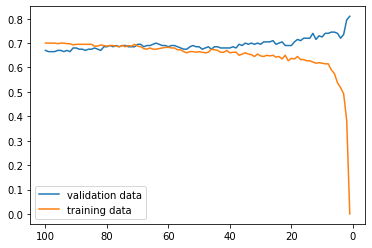

In [13]:
# Plot the classification error
plt.plot(scores_list_df['k-value'], scores_list_df['Classificaion error(validation data)'], label = "validation data")
plt.plot(scores_list_df['k-value'], scores_list_df['Classificaion error(training data)'], label = "training data")
plt.gca().invert_xaxis()
plt.legend()

In [14]:
# Selects the best classifier
best_k_value=scores_list_df['Classificaion error(validation data)'].idxmin()+1
best_k_value

92

In [19]:
# Predicts the generalisation error and the accuracy rate using the test data set.
test_data_normalised_x = test_data_normalised.copy().drop(columns=['Duration']).values
test_data_normalised_y = test_data['Duration']

test_data_normalised_y_predicted = classifier.predict(test_data_normalised_x)
testing_data_error_ratio= 1-metrics.accuracy_score(test_data_normalised_y,test_data_normalised_y_predicted,normalize=True)

accuracy_rate = 1-testing_data_error_ratio
print('Accuracy rate of predicting the duration of customer is',accuracy_rate)

Accuracy rate of predicting the duration of customer is 0.38
